In [1]:
import os

import signac
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from cmeutils.structure import bond_distribution, angle_distribution, dihedral_distribution
from msibi.utils.smoothing import savitzky_golay

In [3]:
def generate_color_gradient(start_color, end_color, num_steps):
    """Generate a gradient of colors between two given colors.

    Parameters:
    - start_color: Starting color in RGB format (e.g., [r, g, b])
    - end_color: Ending color in RGB format (e.g., [r, g, b])
    - num_steps: Number of steps in the gradient

    Returns:
    - colors: List of color codes representing the gradient
    """
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [start_color, end_color])
    norm = mcolors.Normalize(vmin=0, vmax=num_steps-1)
    colors = [cmap(norm(i)) for i in range(num_steps)]
    return colors


# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
symbol_dict = {1.0: "o", 0.8: "s", 0.7: "^", 0.6: "d"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 3
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["legend.markerscale"] = 1

SAVE_FIGS = False

In [4]:
def harmonic_bond(l, k, l0):
    return 0.5 * k * (l - l0)**2


def periodic_dihedral(phi, k, phi0):
    return 0.5 * k * (1 + -np.cos(phi - phi0))

In [5]:
target_project = signac.get_project(
    "/home/erjank_project/PPS-MSIBI/pps-msibi/training-runs/single-chains"
)
target_job_id = "29a7f0d216700e7c8534b8c11140ba06"
target_job = target_project.open_job(id=target_job_id)
gsd_path = "target_1monomer_per_bead.gsd"

bonds_nbins = 100
bonds_xmin=0
bonds_x_max=3.0

dih_nbins = 60

# Bond stretching:

In [5]:
bdist = bond_distribution(
    gsd_file=target_job.fn(gsd_path),
    A_name="A",
    B_name="A",
    bins=bonds_nbins,
    l_min=0,
    l_max=3.0,
    normalize=True,
    histogram=True,
    start=-100,
    stop=-1
)

inverse = -target_job.sp.kT * np.log(bdist[:,1])
inverse_indices = np.where(np.isfinite(inverse))[0]

/tmp/ipykernel_72554/4110372222.py:14: RuntimeWarning: divide by zero encountered in log
  inverse = -target_job.sp.kT * np.log(bdist[:,1])


In [6]:
popt, pcov = curve_fit(
    harmonic_bond,
    bdist[:,0][inverse_indices],
    inverse[inverse_indices],
    p0=[300, 1.5]
)

k_fit, l_fit = popt

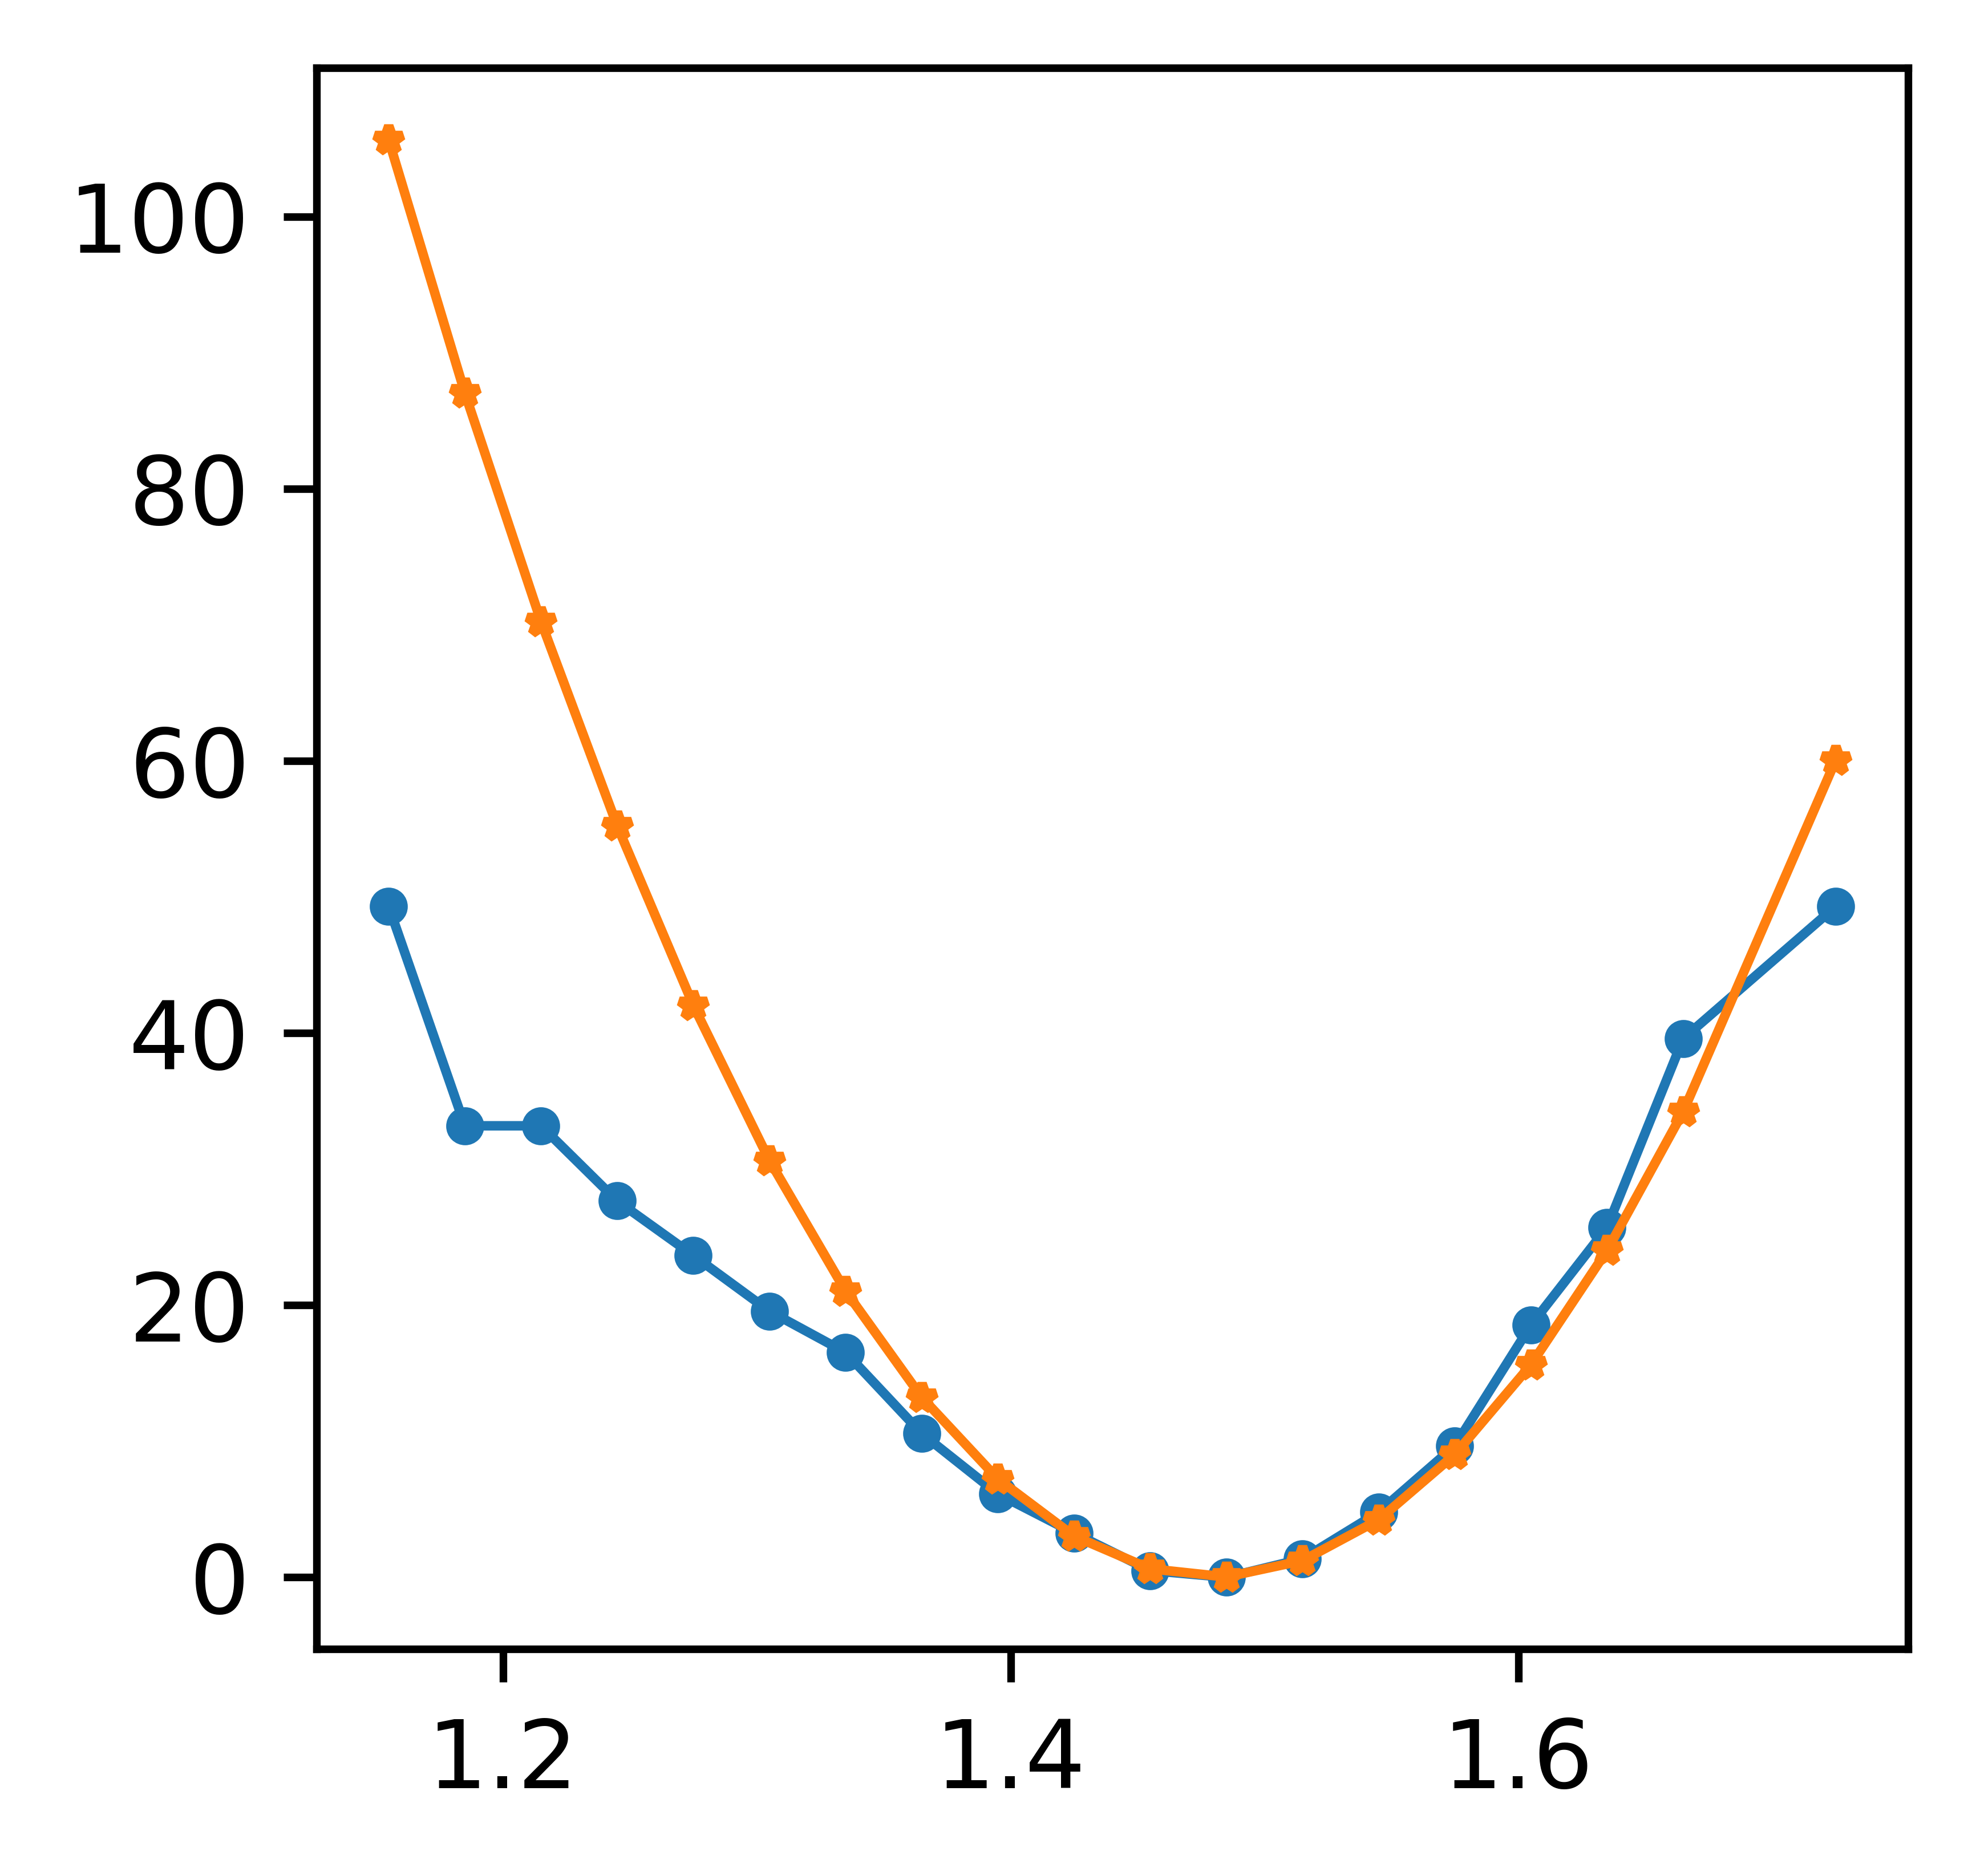

In [7]:
plt.plot(
    bdist[:,0][inverse_indices],
    inverse[inverse_indices] - np.min(inverse[inverse_indices]),
    "o-",
    label="Boltzmann Inverse"
)


plt.plot(
    bdist[:,0][inverse_indices],
    harmonic_bond(bdist[:,0][inverse_indices], k=2000, l0=1.48),
    "*-",
    label="Harmonic Fit"
)


# Dihedrals

In [14]:
ddist = dihedral_distribution(
    gsd_file=target_job.fn(gsd_path),
    A_name="A",
    B_name="A",
    C_name="A",
    D_name="A",
    bins=dih_nbins,
    normalize=True,
    histogram=True,
    start=-100,
    stop=-1
)

inverse = -target_job.sp.kT * np.log(ddist[:,1])
inverse_indices = np.where(np.isfinite(inverse))[0]

In [20]:
popt, pcov = curve_fit(
    periodic_dihedral,
    ddist[:,0][inverse_indices],
    inverse[inverse_indices],
    p0=[300, 0]
)

k_fit, phi_fit = popt

In [22]:
k_fit, phi_fit

(20.12751796123445, 0.02434134166715483)

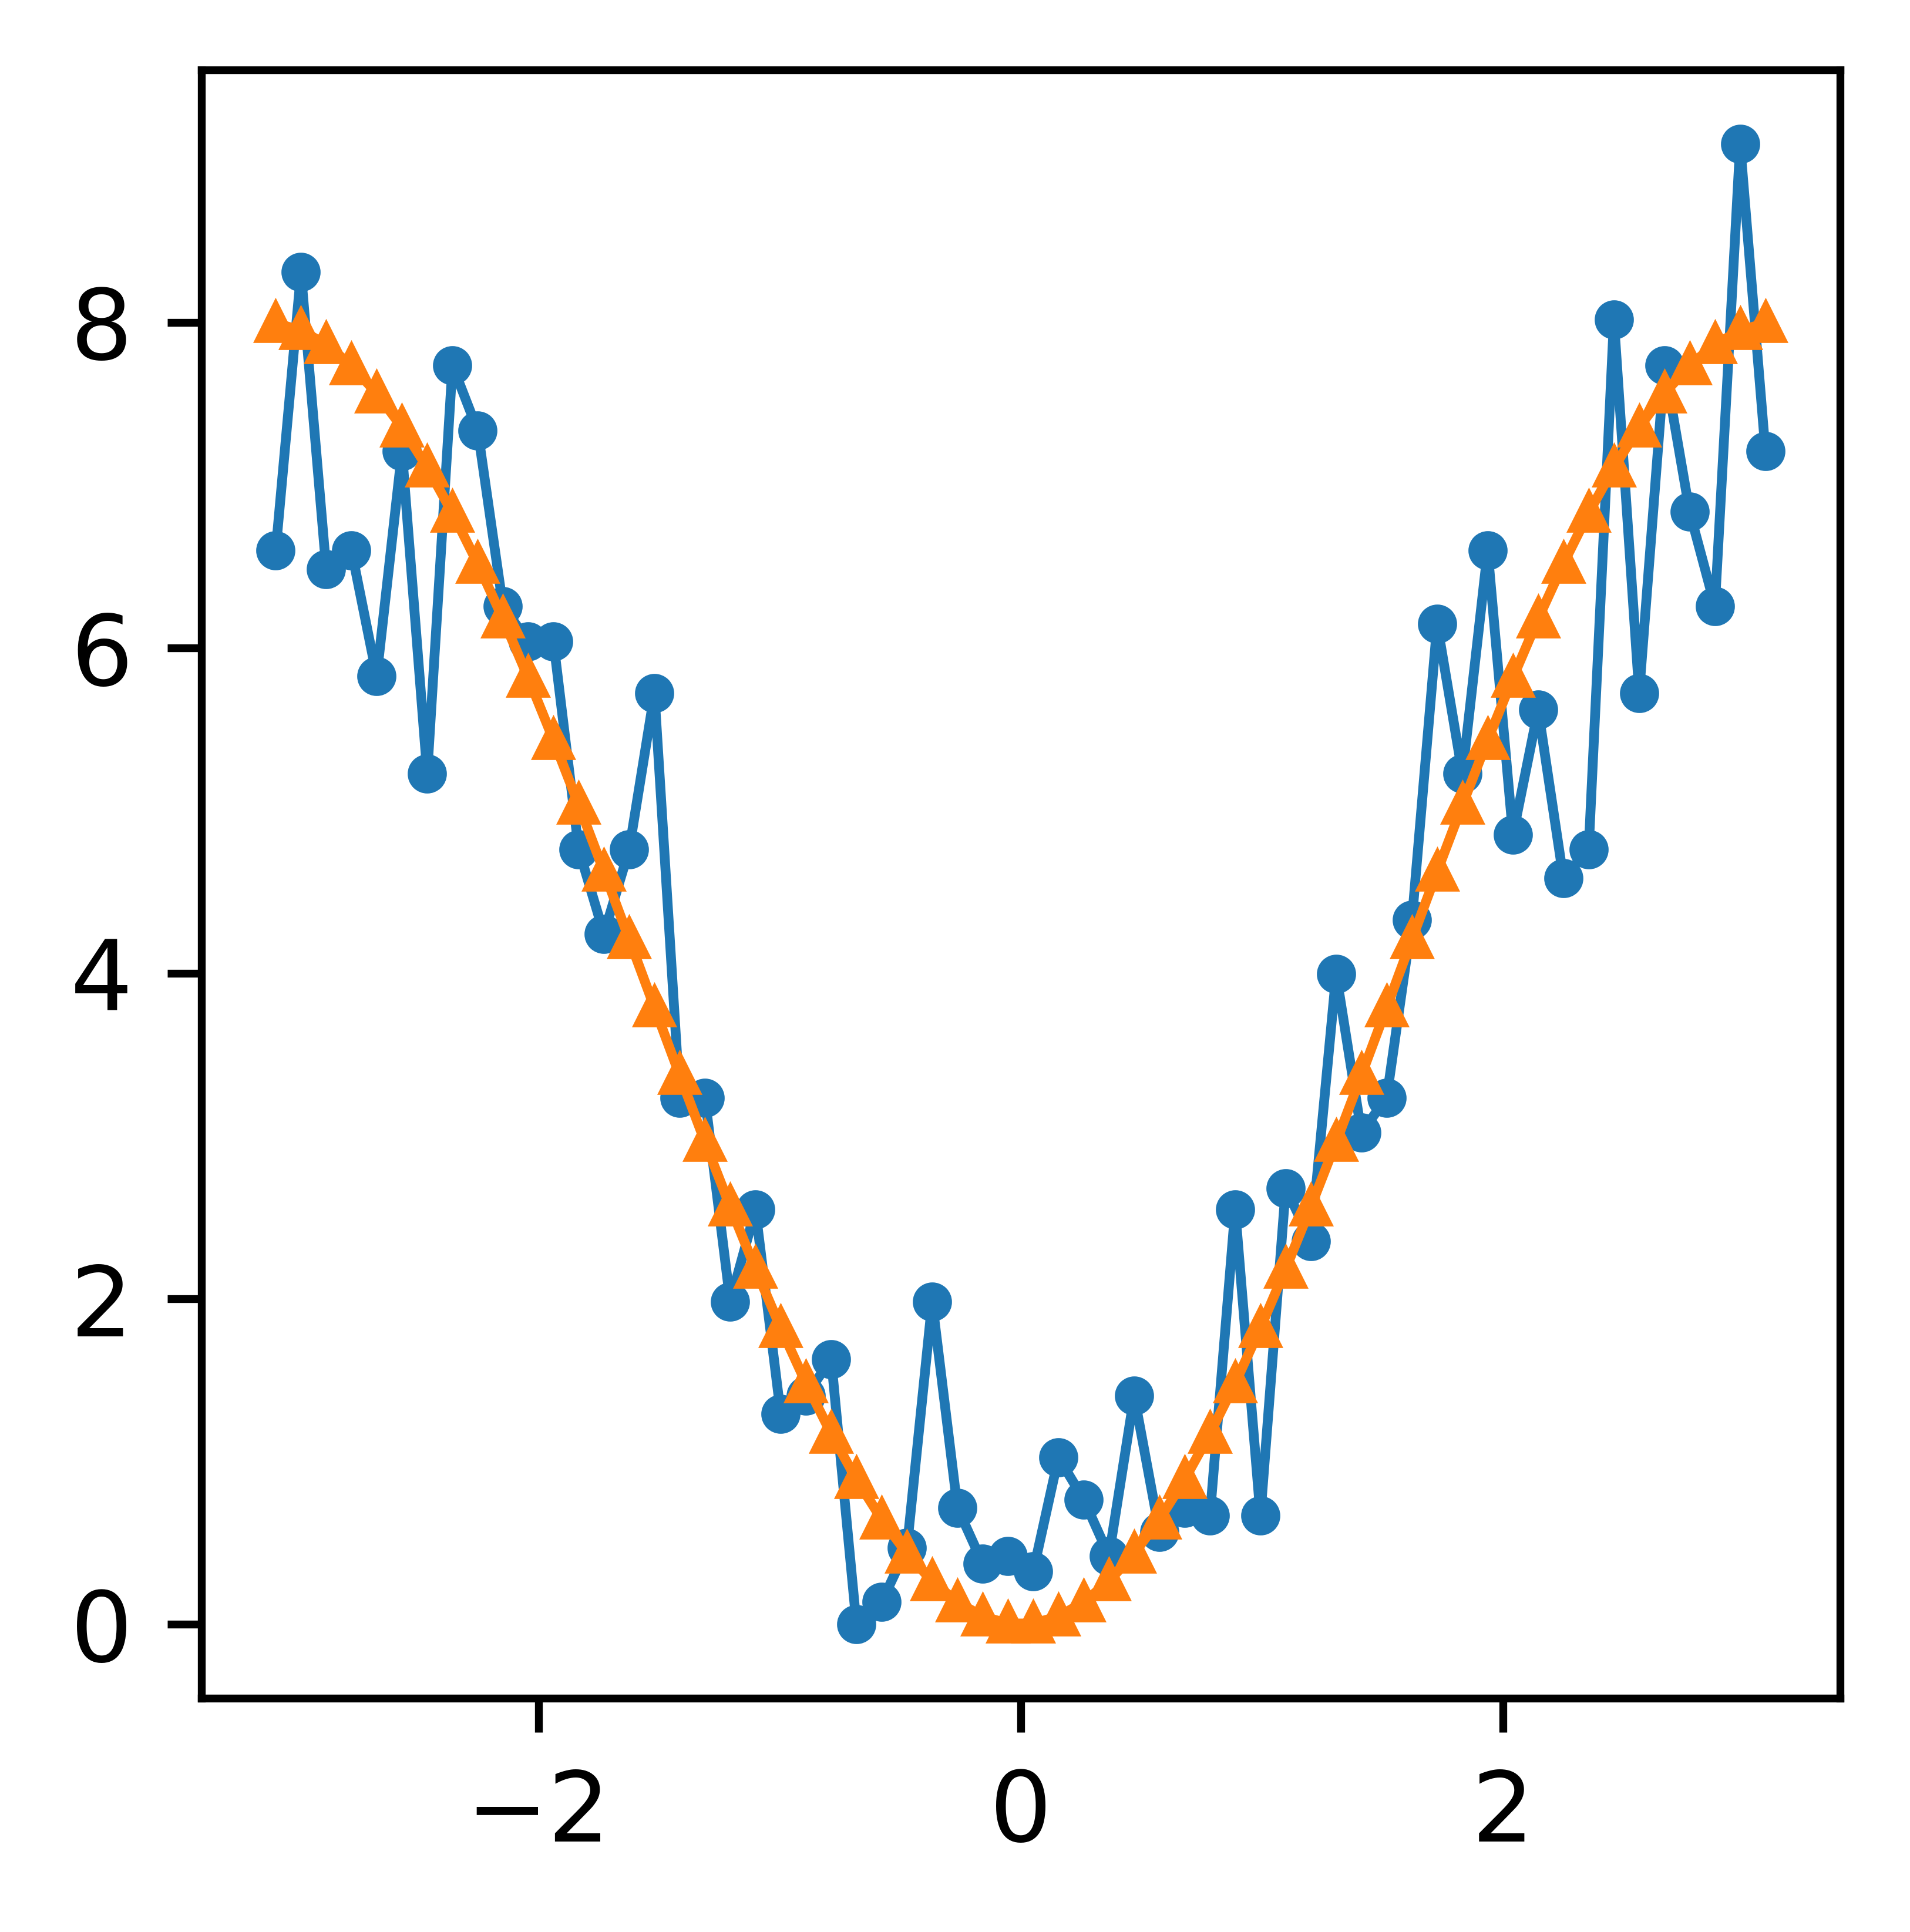

In [27]:
plt.plot(
    ddist[:,0][inverse_indices],
    inverse[inverse_indices] - np.min(inverse[inverse_indices]),
    "o-",
    label="Boltzmann Inverse"
)


#plt.plot(
#    ddist[:,0][inverse_indices],
#    periodic_dihedral(ddist[:,0][inverse_indices], k=k_fit, phi0=phi_fit),
#    "*-",
#    label="Scipy Fit"
#)

plt.plot(
    ddist[:,0][inverse_indices],
    periodic_dihedral(ddist[:,0][inverse_indices], k=8, phi0=0),
    "^-",
    label="Periodic Fit"
)

In [10]:
phi_fit

-3.1110845296549954

In [7]:
for job in angle_project:
    ua_project = signac.get_project(job.sp.single_chain_path)
    ua_job = ua_project.open_job(id=job.sp.single_chain_job_id)
    target = dihedral_distribution(
        gsd_file=ua_job.fn("target_1monomer_per_bead.gsd"),
        A_name="A",
        B_name="A",
        C_name="A",
        D_name="A",
        start=-100,
        stop=-1,
        histogram=True,
        normalize=True,
        bins=40
    )
    plt.plot(target[:,0], target[:,1], label="Target", color="k", marker="^")

    cg = dihedral_distribution(
        gsd_file=os.path.join(
            job.path,
            "states",
            "A_7.0",
            "query9.gsd"
        ),
        A_name="A",
        B_name="A",
        C_name="A",
        D_name="A",
        start=-100,
        stop=-1,
        histogram=True,
        normalize=True,
        bins=60
    )
    plt.plot(cg[:,0], cg[:,1], label="MSIBI", color="r", marker="o")

plt.legend(loc="upper left")
plt.xlabel("$\Phi$ [rad.]")
plt.ylabel("$P(\Phi)$")
ax.set_xticks([-np.pi, 0, np.pi], ["-$\pi$", 0, "$\pi$"])
plt.ylim(0.07, 0.31)
plt.tight_layout()

NameError: name 'angle_project' is not defined